In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from glob import glob
from skimage.io import imread
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')

### Split original dataset

In [2]:
root_folder = '.'
data_folder = os.path.join(root_folder, 'dataset')
csv_path = os.path.join(data_folder, 'HAM10000_metadata.csv')

train_csv_path = os.path.join(data_folder, 'train.csv')
val_csv_path = os.path.join(data_folder, 'val.csv')
test_csv_path = os.path.join(data_folder, 'test.csv')

In [3]:
data_df = pd.read_csv(csv_path)

In [4]:
train_val, test = train_test_split(data_df, test_size=0.1, stratify=data_df["dx"], random_state=42)
train, val = train_test_split(train_val, test_size=0.2, stratify=train_val["dx"], random_state=42)

In [5]:
print(f"Original: {len(data_df)}")
print(f"Train: {len(train)}")
print(f"Val: {len(val)}")
print(f"Test: {len(test)}")

Original: 10015
Train: 7210
Val: 1803
Test: 1002


In [6]:
dx_dict = {
    'nv': 'Melanocytic nevus',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'vasc': 'Vascular lesion',
    'df': 'Dermatofibroma'
}

data_df['diagnosis'] = data_df['dx'].map(dx_dict.get)
train['diagnosis'] = train['dx'].map(dx_dict.get)
val['diagnosis'] = val['dx'].map(dx_dict.get)
test['diagnosis'] = test['dx'].map(dx_dict.get)

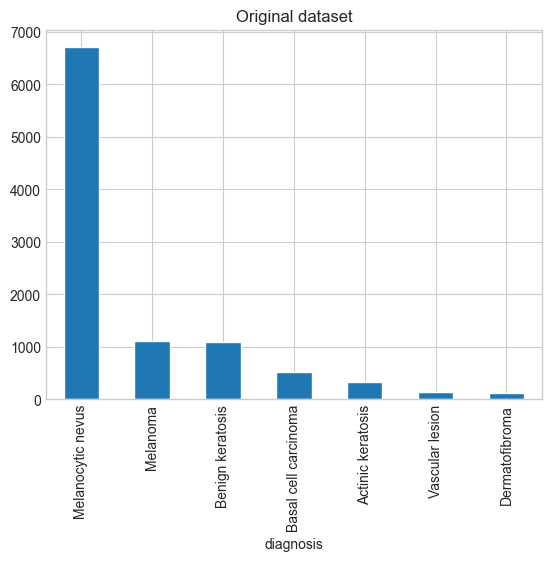

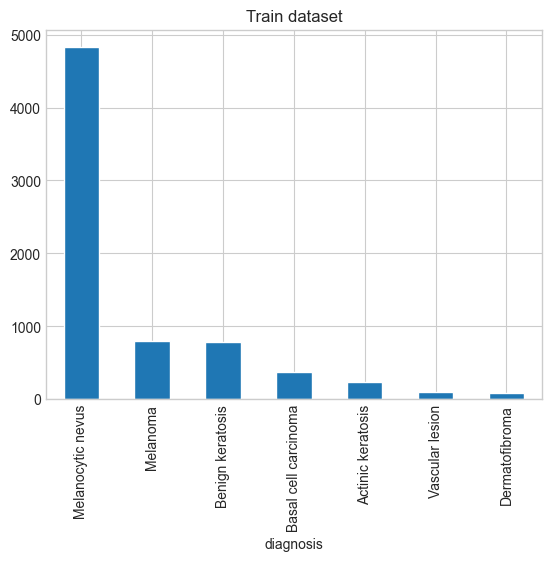

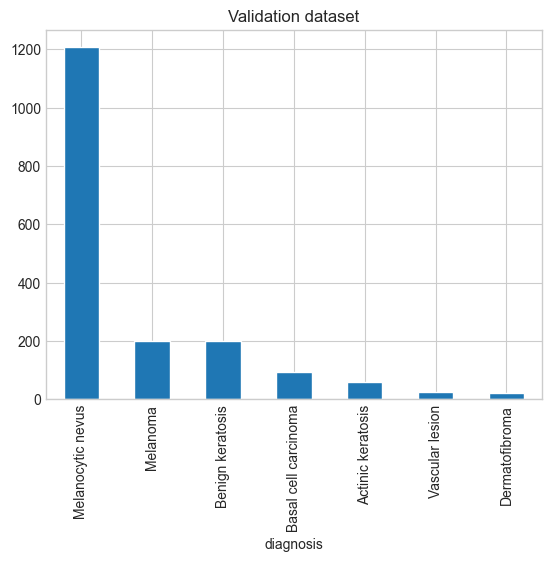

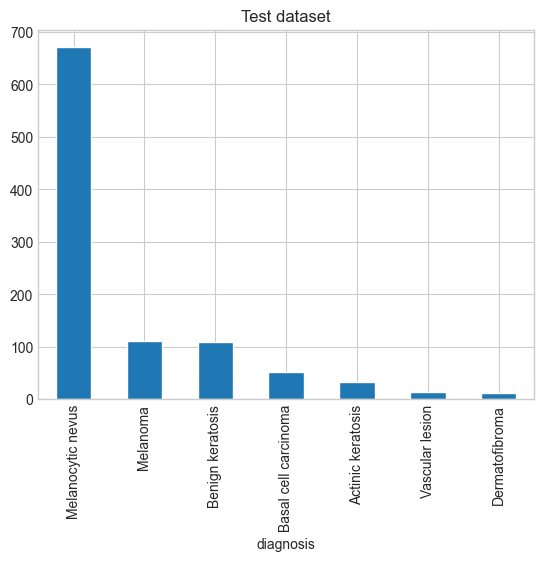

In [7]:
data_df['diagnosis'].value_counts().plot(kind='bar')
plt.title("Original dataset")
plt.show()

train['diagnosis'].value_counts().plot(kind='bar')
plt.title("Train dataset")
plt.show()

val['diagnosis'].value_counts().plot(kind='bar')
plt.title("Validation dataset")
plt.show()

test['diagnosis'].value_counts().plot(kind='bar')
plt.title("Test dataset")
plt.show()

In [8]:
train.to_csv(train_csv_path, index=False)
val.to_csv(val_csv_path, index=False)
test.to_csv(test_csv_path, index=False)

### Balance dataset

In [9]:
folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
augmented_data_folder = os.path.join(data_folder, 'Augmented_images')

if not os.path.exists(augmented_data_folder):
    os.mkdir(augmented_data_folder)

In [10]:
class_counts = train_val['dx'].value_counts()
class_counts

dx
nv       6034
mel      1002
bkl       989
bcc       463
akiec     294
vasc      128
df        103
Name: count, dtype: int64

In [11]:
jpg_files = []
for folder in folders:
    jpg_files.extend(glob(os.path.join(data_folder, folder, '*.jpg')))

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in jpg_files}

train_val['path'] = train_val['image_id'].map(imageid_path_dict.get)

In [12]:
def get_data_generator():
    return tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           brightness_range=(0.8, 1.5),
                                                           shear_range=0.1,
                                                           zoom_range=0.1,
                                                           fill_mode='nearest',
                                                           horizontal_flip=True,
                                                           vertical_flip=True,
                                                           dtype=np.float32)

Found 1 validated image filenames.


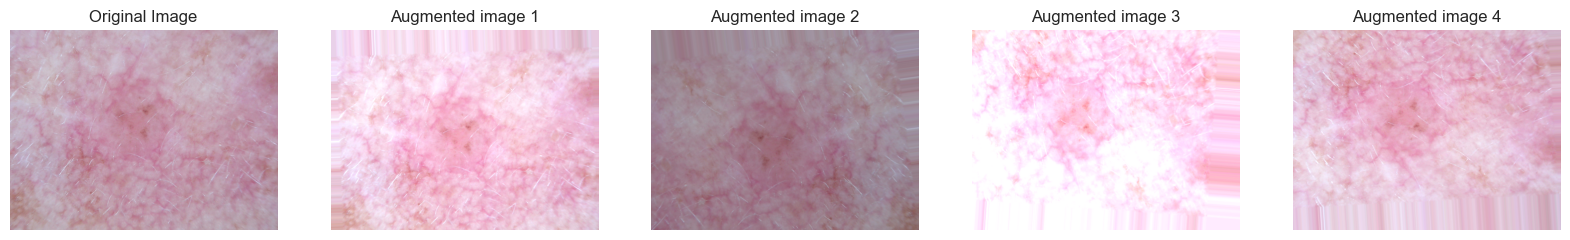

In [18]:
subset = train_val.sample(n=1)
image = imread(subset.iloc[0]["path"])
img_size = image.shape[:2]

data_gen = get_data_generator()
aug_gen = data_gen.flow_from_dataframe(subset, x_col='path', y_col=None, target_size=img_size,
                                        class_mode=None, batch_size=1, shuffle=False, 
                                        save_to_dir=None, save_prefix=None, color_mode='rgb',
                                        save_format='jpg')

n_augmentations = 4
fig, axes = plt.subplots(1, 5, figsize=(4*5, 3))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

for i in range(n_augmentations):
    img = next(aug_gen)[0]
    img = np.clip(img, 0, 255).astype(np.uint8)
    axes[i+1].imshow(img)
    axes[i+1].set_title(f'Augmented image {i+1}')
    axes[i+1].axis('off')

In [19]:
augmented_df = pd.DataFrame(columns=train_val.columns)
count = 1300
data_gen = get_data_generator()

for label in class_counts.index:
    class_subset = train_val[train_val['dx'] == label]
    if len(class_subset) < count:          
        n_augmentations = count - len(class_subset)
        aug_gen = data_gen.flow_from_dataframe(class_subset, x_col='path', y_col=None, target_size=img_size,
                                        class_mode=None, batch_size=1, shuffle=False, 
                                        save_to_dir=None, save_prefix=None, color_mode='rgb',
                                        save_format='jpg')
        new_data = []
        generated_images = 0
        iteration = 0

        while generated_images < n_augmentations:
            for i in range(len(aug_gen)):
                if generated_images >= n_augmentations:
                    break
                img = next(aug_gen)[0]  
                original_row = class_subset.iloc[aug_gen.index_array[i]]  
                new_file_name = f"{original_row['image_id']}_aug_{i}_{iteration}"
                new_path = os.path.join(augmented_data_folder, f"{new_file_name}.jpg") 
             
                tf.keras.preprocessing.image.save_img(new_path, img)

                new_row = original_row.copy()
                new_row['path'] = new_path
                new_row['image_id'] = new_file_name
                new_data.append(new_row)

                generated_images += 1

            iteration += 1

        new_df = pd.DataFrame(new_data)
        augmented_df = pd.concat([new_df, augmented_df], ignore_index=True)
    else:
        n_deletions = len(class_subset) - count
        rows_to_remove = class_subset.sample(n=n_deletions, random_state=42)
        train_val = train_val.drop(rows_to_remove.index)

Found 1002 validated image filenames.
Found 989 validated image filenames.
Found 463 validated image filenames.
Found 294 validated image filenames.
Found 128 validated image filenames.
Found 103 validated image filenames.


In [20]:
balanced_train_val = pd.concat([augmented_df, train_val], ignore_index=True)
class_counts = balanced_train_val['dx'].value_counts()
class_counts

dx
df       1300
vasc     1300
akiec    1300
bcc      1300
bkl      1300
mel      1300
nv       1300
Name: count, dtype: int64

In [21]:
balanced_train_val.drop(["path"], axis=1, inplace=True)

### Split balanced dataset

In [22]:
balanced_train_csv_path = os.path.join(data_folder, 'balanced_train.csv')
balanced_val_csv_path = os.path.join(data_folder, 'balanced_val.csv')

In [23]:
balanced_train, balanced_val = train_test_split(balanced_train_val, test_size=0.2, stratify=balanced_train_val["dx"], random_state=42)

In [24]:
print(f"Original: {len(balanced_train_val)}")
print(f"Train: {len(balanced_train)}")
print(f"Val: {len(balanced_val)}")

Original: 9100
Train: 7280
Val: 1820


In [25]:
balanced_train['diagnosis'] = balanced_train['dx'].map(dx_dict.get)
balanced_val['diagnosis'] = balanced_val['dx'].map(dx_dict.get)

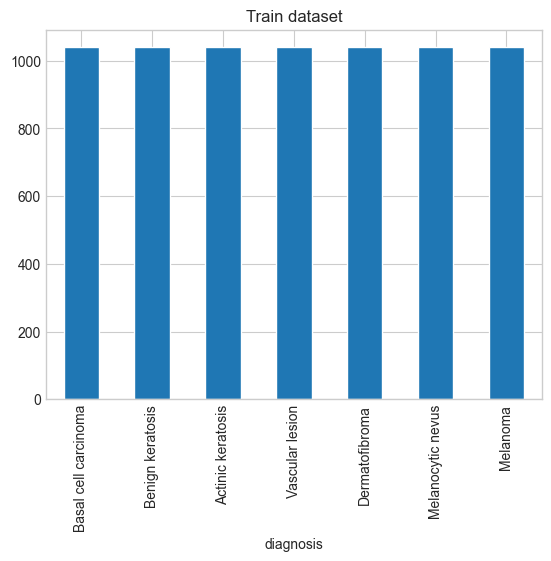

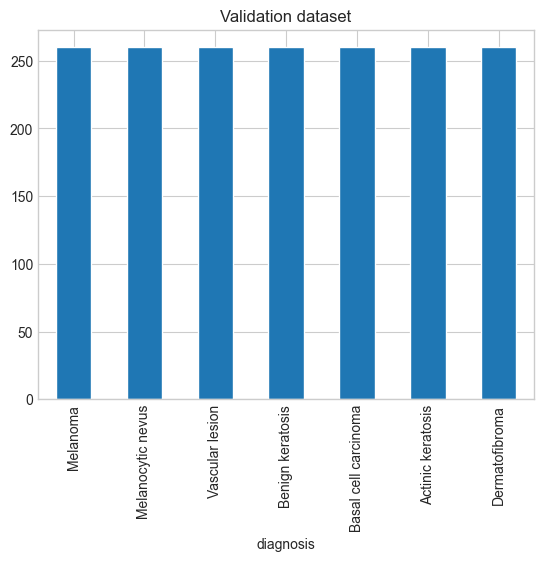

In [26]:
balanced_train['diagnosis'].value_counts().plot(kind='bar')
plt.title("Train dataset")
plt.show()

balanced_val['diagnosis'].value_counts().plot(kind='bar')
plt.title("Validation dataset")
plt.show()

In [27]:
balanced_train.to_csv(balanced_train_csv_path, index=False)
balanced_val.to_csv(balanced_val_csv_path, index=False)